### S&P 500 One step Ahead Return prediction

We are going to mess around with predicting the S&P 500 index return. Since we are trying to predict the actual return, this is a *regression* problem rather than a *classification* problem. We will deal with classification in another study. 

We want to use a combination of features which will feed into a complex neural network model. The features have three categories: 
* **Technical Features** 
    * RSI 
    * Stochastic RSI 
    * Bollinger Bands combination 
    * Normalized Average True Range 
* **Macroeconomic Features** 
    * Historical 10 year yield movements
    * Historical 2 year yield movements
* **Sequence to Sequence Features** 
    * Sequences of the 10 previous daily returns on the index

In [4]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt
import talib as ta

from full_fred.fred import Fred

In [8]:
ticker = '^GSPC'

data = yf.download(ticker, start='1970-01-01', progress=False)

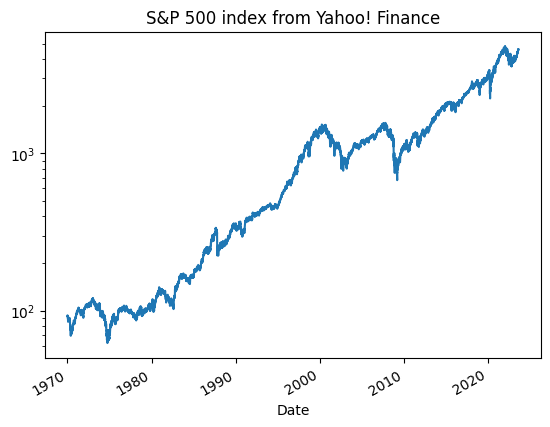

In [9]:
data['Close'].plot()
plt.title("S&P 500 index from Yahoo! Finance")
plt.yscale("log")
plt.show()

### Creating technical features



In [10]:
rsi = ta.RSI(data['Close'])
rsi.name = 'RSI'

adx = ta.ADX(
    high = data['High'], 
    low = data['Low'], 
    close = data['Close']
)

adx.name = 'ADX'

fastk, fastd = ta.STOCHRSI(data['Close'], timeperiod = 14, fastk_period=14, fastd_period=3)
fastk.name = 'STOCH_RSI'

natr = ta.NATR(
    high = data['High'], 
    low = data['Low'], 
    close = data['Close']
)

natr.name = 'NATR'

def create_bband_features(series: pd.Series, timeperiod: int = 20) -> pd.DataFrame: 
    upper_band, middle_band, lower_band = ta.BBANDS(series, timeperiod = timeperiod, nbdevup = 2, nbdevdn = 2)

    bbands_df = pd.concat([upper_band, middle_band, lower_band, series], axis = 1)
    bbands_df.columns = ['upper', 'middle', 'lower', 'close']

    bbands_df['upper_ratio'] = bbands_df['upper'].sub(bbands_df['close']).div(bbands_df['close'])
    bbands_df['lower_ratio'] = bbands_df['close'].sub(bbands_df['lower']).div(bbands_df['lower'])
    bbands_df['middle_ratio'] = bbands_df['close'].sub(bbands_df['lower']).div(bbands_df['upper'].sub(bbands_df['lower']))
    bbands_df['bb_squeeze'] = bbands_df['upper'].sub(bbands_df['lower']).div(bbands_df['middle'])

    return bbands_df[['upper_ratio', 'lower_ratio', 'middle_ratio', 'bb_squeeze']]


bband_features = create_bband_features(series = data['Close'])


In [11]:
technical_features = pd.concat([rsi, adx, fastk, natr, bband_features], axis = 1)

In [12]:
technical_features

,RSI,ADX,STOCH_RSI,NATR,upper_ratio,lower_ratio,middle_ratio,bb_squeeze
Date,,,,,,,,
1970-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-07-25,71.334010,39.750872,77.641068,0.777382,0.007935,0.051170,0.859836,0.057792
2023-07-26,71.148677,39.976458,76.510055,0.776539,0.009734,0.048271,0.825506,0.056814
2023-07-27,63.774527,40.569114,25.269634,0.849326,0.016271,0.037721,0.690792,0.053154


### Sequence features

We want to use lags of the daily return as another set. This is going to go into the LSTM section of our neural net. 

In [13]:
daily_close_to_close_returns = data['Close'].pct_change()

windowed_data = pd.DataFrame() 

WINDOW_LENGTH = 10

for i in range(1, WINDOW_LENGTH+1): 

    prev = daily_close_to_close_returns.shift(i)
    windowed_data[f'Prev_{i}'] = prev

In [14]:
windowed_data

,Prev_1,Prev_2,Prev_3,Prev_4,Prev_5,Prev_6,Prev_7,Prev_8,Prev_9,Prev_10
Date,,,,,,,,,,
1970-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-06,0.004946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-07,-0.006848,0.004946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-08,-0.002047,-0.006848,0.004946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-07-25,0.004034,0.000324,-0.006757,0.002358,0.007117,0.003855,-0.001024,0.008470,0.007411,0.006742
2023-07-26,0.002815,0.004034,0.000324,-0.006757,0.002358,0.007117,0.003855,-0.001024,0.008470,0.007411
2023-07-27,-0.000155,0.002815,0.004034,0.000324,-0.006757,0.002358,0.007117,0.003855,-0.001024,0.008470


### Macroeconomic data

Macroeconomic data for us is basically anything that is not endogenous to the time series itself. Ideally there are other things happening in the market which might affect what's happening to the S&P 500 on a daily basis. At least that movement or even level can give us a better conditional distribution on what the returns should be on a given day. Some initial ideas are: 
* Momentum in 10 year yield --> maybe look at the change over the past day, week
* Momentum in the 2 year yield --> over the past day, week

In [15]:
fred = Fred()

In [40]:
ten_year_yield = fred.get_series_df(series_id='DGS10')
two_year_yield = fred.get_series_df(series_id='DGS2')

In [41]:
ten_year_yield['date'] = pd.to_datetime(ten_year_yield['date']) 
ten_year_yield.set_index('date', inplace=True)

ten_year_yield['value']  = ten_year_yield['value'].replace('.', np.nan)
ten_year_yield.dropna(inplace=True) 
ten_year_yield['value'] = ten_year_yield['value'].astype(float)

ten_year_yield = ten_year_yield['value']
ten_year_yield.name = '10_year'

In [44]:
two_year_yield['date'] = pd.to_datetime(two_year_yield['date']) 
two_year_yield.set_index('date', inplace=True)

two_year_yield['value']  = two_year_yield['value'].replace('.', np.nan)
two_year_yield.dropna(inplace=True) 
two_year_yield['value'] = two_year_yield['value'].astype(float)

two_year_yield = two_year_yield['value']
two_year_yield.name = '2_year'

For each of these rates, we are going to look at the change in the log of the rate. This is because the rates tend to move in percentages of each other rather than in absolute terms. 

In [65]:
log_10_year_change = ten_year_yield.div(100).apply(np.log1p).diff()
log_2_year_change = two_year_yield.div(100).apply(np.log1p).diff()


<Axes: xlabel='date'>

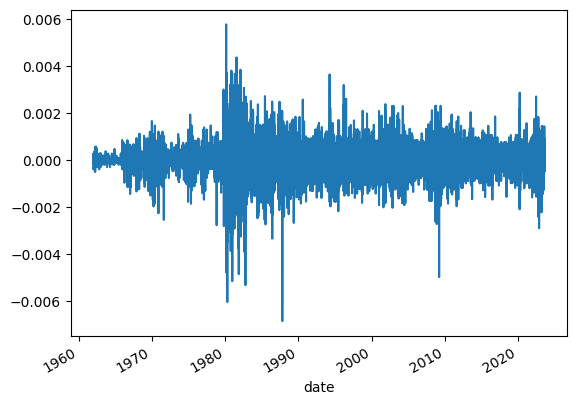

In [66]:
log_10_year_change.plot()

<Axes: xlabel='date'>

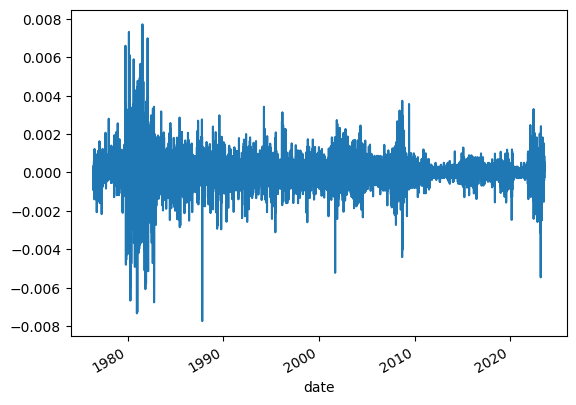

In [67]:
log_2_year_change.plot()

In [64]:
ten_year_yield/100

date
1962-01-02    0.0406
1962-01-03    0.0403
1962-01-04    0.0399
1962-01-05    0.0402
1962-01-08    0.0403
               ...  
2023-07-24    0.0386
2023-07-25    0.0391
2023-07-26    0.0386
2023-07-27    0.0401
2023-07-28    0.0396
Name: 10_year, Length: 15379, dtype: float64